In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Step 1: Connect to SQL Server
# Define connection parameters
server = 'DESKTOP-DGDUOBT\SQLEXPRESS'  
database = 'MedicareAnalysis'
username = ''  
password = ''  
driver = '{ODBC Driver 17 for SQL Server}'   

try:
    conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes')
    print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful!


In [4]:
# Step 2: Load data from SQL tables
Medicare_Charge_In = pd.read_sql_query("SELECT * FROM Medicare_Charge_Inpatient_DRG", conn)
Medicare_Charge_Out = pd.read_sql_query("SELECT * FROM Medicare_Charge_Outpatient_APC", conn)
Provider_Charge_In = pd.read_sql_query("SELECT * FROM Provider_Charge_Inpatient_DRG", conn)
Provider_Charge_Out = pd.read_sql_query("SELECT * FROM Provider_Charge_Outpatient_APC", conn)
Patient_history = pd.read_sql_query("SELECT * FROM Patient_history", conn)
Review_patient = pd.read_sql_query("SELECT * FROM Review_patient_history", conn)
Transaction = pd.read_sql_query("SELECT * FROM Transaction_", conn)
Review_transaction = pd.read_sql_query("SELECT * FROM Review_transaction", conn)

# Step 3: Close the connection after loading data
conn.close()
print("Data loaded successfully & connection closed.")

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\2473003980.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Medicare_Charge_In = pd.read_sql_query("SELECT * FROM Medicare_Charge_Inpatient_DRG", conn)


ProgrammingError: Attempt to use a closed connection.

## Step 1: Basic Data Exploration

In [4]:
# Display first few rows of each dataset
datasets = {
    'Medicare_Charge_In': Medicare_Charge_In,
    'Medicare_Charge_Out': Medicare_Charge_Out,
    'Provider_Charge_In': Provider_Charge_In,
    'Provider_Charge_Out': Provider_Charge_Out,
    'Patient_history': Patient_history,
    'Review_patient': Review_patient,
    'Transaction': Transaction,
    'Review_transaction': Review_transaction
}

for name, df in datasets.items():
    print(f"\n{name} Dataset:")
    print(df.head())
    print(df.info())
    print(df.describe())
    print(f"Missing values:\n{df.isnull().sum()}")



Medicare_Charge_In Dataset:
                                      DRG_Definition  Total_Discharges  \
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC             37861   
1  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...             37927   
2  064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...             68163   
3  065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...            110983   
4  066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...             62346   

   Average_Covered_Charges  Average_Total_Payments  Average_Medicare_Payments  
0             29228.552734             6902.381348                5514.436035  
1             23924.980469             6809.799316                5791.920410  
2             49186.957031            13614.616211               12415.825195  
3             30371.273438             8037.269531                6858.688965  
4             23300.062500             5762.881836                4508.202637  
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [5]:
for name, df in datasets.items():
    print(f"\n{name} Dataset:")
    print(df.head(2))
    print(df.info())


Medicare_Charge_In Dataset:
                                      DRG_Definition  Total_Discharges  \
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC             37861   
1  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...             37927   

   Average_Covered_Charges  Average_Total_Payments  Average_Medicare_Payments  
0             29228.552734             6902.381348                5514.436035  
1             23924.980469             6809.799316                5791.920410  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DRG_Definition             100 non-null    object 
 1   Total_Discharges           100 non-null    int64  
 2   Average_Covered_Charges    100 non-null    float64
 3   Average_Total_Payments     100 non-null    float64
 4   Average_Medicare_Payments  100 non-null    float64
dtypes: float

### Step 2: Visual Explorationm

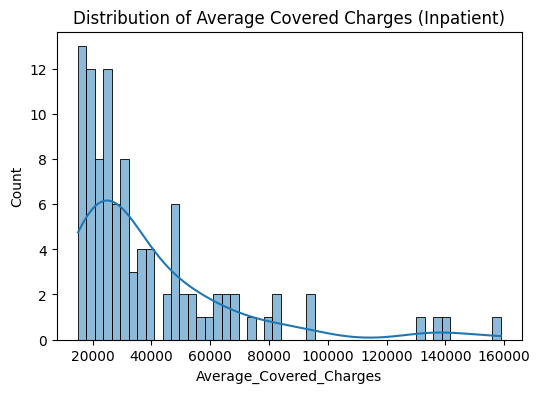

In [9]:
# Distribution of Average Covered Charges - Inpatient
plt.figure(figsize=(6, 4))
sns.histplot(Medicare_Charge_In['Average_Covered_Charges'], bins=50, kde=True)
plt.title('Distribution of Average Covered Charges (Inpatient)')
plt.show()

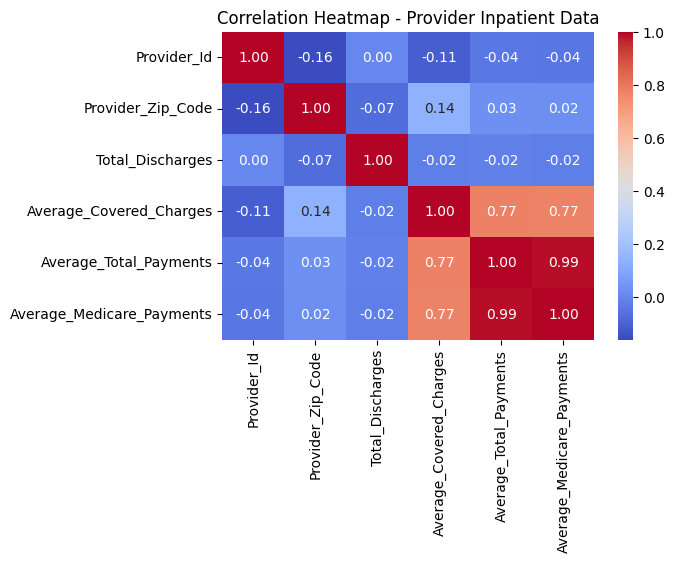

In [15]:
# Select only numeric columns for correlation
numeric_cols = Provider_Charge_In.select_dtypes(include=['number'])

# Correlation heatmap for inpatient provider data
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap - Provider Inpatient Data')
plt.show()


###  Step 3: Outlier Detection

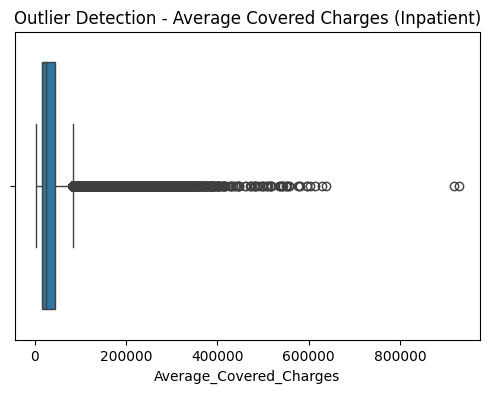

In [11]:
# Boxplot to detect outliers in Average Covered Charges
plt.figure(figsize=(6, 4))
sns.boxplot(x=Provider_Charge_In['Average_Covered_Charges'])
plt.title('Outlier Detection - Average Covered Charges (Inpatient)')
plt.show()

### Step 4: Provider & Region Analysis

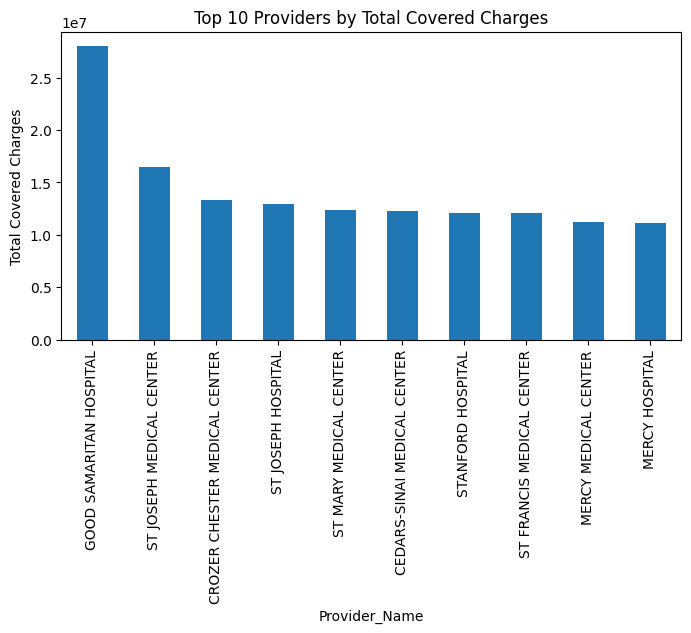

In [14]:
# Top providers by total charges
top_providers = Provider_Charge_In.groupby('Provider_Name')['Average_Covered_Charges'].sum().sort_values(ascending=False).head(10)
top_providers.plot(kind='bar', figsize=(8, 4), title='Top 10 Providers by Total Covered Charges')
plt.ylabel('Total Covered Charges')
plt.show()

#### Flag suspicious patterns: Missing age + no income + high-cost procedures

In [23]:
import numpy as np

# Convert 'age' and 'income' to numeric (errors='coerce' for invalid values)
Patient_history['age'] = pd.to_numeric(Patient_history['age'], errors='coerce')
Patient_history['income'] = pd.to_numeric(Patient_history['income'], errors='coerce').fillna(0)  # Null income = 0


In [24]:
# Identify high-cost procedures (top 5% charges from inpatient & outpatient)
high_cost_threshold_in = Provider_Charge_In['Average_Covered_Charges'].quantile(0.95)
high_cost_threshold_out = Provider_Charge_Out['Average_Estimated_Submitted_Charges'].quantile(0.95)

In [25]:
# Merge transaction data with high-cost procedures (inpatient & outpatient combined)
high_cost_in = Provider_Charge_In[Provider_Charge_In['Average_Covered_Charges'] >= high_cost_threshold_in][['Provider_Id']]
high_cost_out = Provider_Charge_Out[Provider_Charge_Out['Average_Estimated_Submitted_Charges'] >= high_cost_threshold_out][['Provider_Id']]

high_cost_providers = pd.concat([high_cost_in, high_cost_out]).drop_duplicates()

In [26]:
import pandas as pd
import numpy as np

# Convert 'age' and 'income' to numeric (treat null income as 0)
Patient_history['age'] = pd.to_numeric(Patient_history['age'], errors='coerce')
Patient_history['income'] = pd.to_numeric(Patient_history['income'], errors='coerce').fillna(0)

# Extract codes from DRG_Definition and APC for mapping with global_proc_id
Provider_Charge_In['DRG_Code'] = Provider_Charge_In['DRG_Definition'].str.extract(r'^(\d+)').astype(float)
Provider_Charge_Out['APC_Code'] = Provider_Charge_Out['APC'].str.extract(r'^(\d+)').astype(float)

# Identify high-cost procedures (top 5% threshold)
high_cost_in_threshold = Provider_Charge_In['Average_Covered_Charges'].quantile(0.95)
high_cost_out_threshold = Provider_Charge_Out['Average_Estimated_Submitted_Charges'].quantile(0.95)

high_cost_in = Provider_Charge_In[Provider_Charge_In['Average_Covered_Charges'] >= high_cost_in_threshold]['DRG_Code']
high_cost_out = Provider_Charge_Out[Provider_Charge_Out['Average_Estimated_Submitted_Charges'] >= high_cost_out_threshold]['APC_Code']

# Merge patient and transaction data
patient_txn = pd.merge(Patient_history, Transaction, on='id', how='inner')

# Flag suspicious patterns: Missing age + no income + high-cost procedure
patient_txn['Suspicious_Flag'] = np.where(
    (patient_txn['age'].isna()) &
    (patient_txn['income'] == 0) &
    (
        (patient_txn['global_proc_id'].isin(high_cost_in)) |
        (patient_txn['global_proc_id'].isin(high_cost_out))
    ),
    1, 0
)

# Output suspicious records
suspicious = patient_txn[patient_txn['Suspicious_Flag'] == 1]
print(f"Total suspicious patients flagged: {suspicious.shape[0]}")
suspicious.head()


Total suspicious patients flagged: 157185


,id,age,gender,income,global_proc_id,count,Suspicious_Flag
32,965505524,NaN,F,0.0,19,1,1
34,489607469,NaN,M,0.0,19,1,1
38,736990877,NaN,M,0.0,20,1,1
39,385159983,NaN,F,0.0,19,1,1
47,534883908,NaN,M,0.0,19,1,1


## Data Cleaning & Feature Engineering

In [5]:
# Fill 'age' and 'income' with mode for balanced imputation

# Data Cleaning: Patient History
Patient_history['age'].fillna(Patient_history['age'].mode()[0], inplace=True)
Patient_history['income'].fillna(Patient_history['income'].mode()[0], inplace=True)

# Data Cleaning: Review Patient History
Review_patient['age'].fillna(Review_patient['age'].mode()[0], inplace=True)
Review_patient['income'].fillna(Review_patient['income'].mode()[0], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\372903628.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Patient_history['age'].fillna(Patient_history['age'].mode()[0], inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\372903628.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [6]:
Review_patient.isnull().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [7]:
# Feature Engineering: Extract code from DRG_Definition (Inpatient)
Medicare_Charge_In['DRG_Code'] = Medicare_Charge_In['DRG_Definition'].str.extract(r'(\d+)').astype(int)
Provider_Charge_In['DRG_Code'] = Provider_Charge_In['DRG_Definition'].str.extract(r'(\d+)').astype(int)

# Feature Engineering: Extract code from APC (Outpatient)
Medicare_Charge_Out['APC_Code'] = Medicare_Charge_Out['APC'].str.extract(r'(\d+)').astype(int)
Provider_Charge_Out['APC_Code'] = Provider_Charge_Out['APC'].str.extract(r'(\d+)').astype(int)

# Feature Engineering: Aggregations for Transaction data
transaction_agg = Transaction.groupby('id').agg({
    'global_proc_id': ['nunique', 'count'],
    'count': 'sum'
}).reset_index()
transaction_agg.columns = ['id', 'unique_procedures', 'total_procedures_count', 'total_counts']

# Merge Patient and Transaction Aggregations
patient_txn_agg = pd.merge(Patient_history, transaction_agg, on='id', how='left')

# Replace NaN after merge with 0 for aggregation columns
patient_txn_agg[['unique_procedures', 'total_procedures_count', 'total_counts']] = \
    patient_txn_agg[['unique_procedures', 'total_procedures_count', 'total_counts']].fillna(0)

# Final dataset ready for preprocessing and modeling
print("✅ Data Cleaning & Feature Engineering Completed.")


✅ Data Cleaning & Feature Engineering Completed.


## Preprocessing (Encoding, Scaling)

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


# --------------------  Encoding Categorical Variables --------------------

# Encode 'gender'
gender_encoder = LabelEncoder()
all_genders = pd.concat([Patient_history['gender'], Review_patient['gender']])
gender_encoder.fit(all_genders)

Patient_history['gender'] = gender_encoder.transform(Patient_history['gender'])
Review_patient['gender'] = gender_encoder.transform(Review_patient['gender'])

# Encoding 'age' 
age_encoder = LabelEncoder()
all_ages = pd.concat([Patient_history['age'], Review_patient['age']])
age_encoder.fit(all_ages)

Patient_history['age'] = age_encoder.transform(Patient_history['age'])
Review_patient['age'] = age_encoder.transform(Review_patient['age'])

# Encode 'income'
income_encoder = LabelEncoder()
all_income = pd.concat([Patient_history['income'], Review_patient['income']])
income_encoder.fit(all_income)

Patient_history['income'] = income_encoder.transform(Patient_history['income'])
Review_patient['income'] = income_encoder.transform(Review_patient['income'])

# Encode 'Provider_State'
provider_state_encoder = LabelEncoder()
all_states = pd.concat([Provider_Charge_In['Provider_State'], Provider_Charge_Out['Provider_State']])
provider_state_encoder.fit(all_states)

Provider_Charge_In['Provider_State'] = provider_state_encoder.transform(Provider_Charge_In['Provider_State'])
Provider_Charge_Out['Provider_State'] = provider_state_encoder.transform(Provider_Charge_Out['Provider_State'])

# Encode 'Hospital_Referral_Region'
region_encoder = LabelEncoder()
all_regions = pd.concat([Provider_Charge_In['Hospital_Referral_Region'],
                         Provider_Charge_Out['Hospital_Referral_Region_HRR_Description']])
region_encoder.fit(all_regions)

Provider_Charge_In['Hospital_Referral_Region'] = region_encoder.transform(Provider_Charge_In['Hospital_Referral_Region'])
Provider_Charge_Out['Hospital_Referral_Region_HRR_Description'] = region_encoder.transform(
    Provider_Charge_Out['Hospital_Referral_Region_HRR_Description'])

# --------------------  Scaling Numerical Variables --------------------

scaler = StandardScaler()

# Medicare_Charge_In scaling
Medicare_Charge_In[['Total_Discharges', 'Average_Covered_Charges',
                    'Average_Total_Payments', 'Average_Medicare_Payments']] = scaler.fit_transform(
    Medicare_Charge_In[['Total_Discharges', 'Average_Covered_Charges',
                        'Average_Total_Payments', 'Average_Medicare_Payments']])

# Medicare_Charge_Out scaling
Medicare_Charge_Out[['Outpatient_Services', 'Average_Estimated_Submitted_Charges',
                     'Average_Total_Payments']] = scaler.fit_transform(
    Medicare_Charge_Out[['Outpatient_Services', 'Average_Estimated_Submitted_Charges',
                         'Average_Total_Payments']])

# Provider_Charge_In scaling
Provider_Charge_In[['Total_Discharges', 'Average_Covered_Charges',
                    'Average_Total_Payments', 'Average_Medicare_Payments']] = scaler.fit_transform(
    Provider_Charge_In[['Total_Discharges', 'Average_Covered_Charges',
                        'Average_Total_Payments', 'Average_Medicare_Payments']])

# Provider_Charge_Out scaling
Provider_Charge_Out[['Outpatient_Services', 'Average_Estimated_Submitted_Charges',
                     'Average_Total_Payments']] = scaler.fit_transform(
    Provider_Charge_Out[['Outpatient_Services', 'Average_Estimated_Submitted_Charges',
                         'Average_Total_Payments']])

# Combine patient data for consistent scaling
combined_patient = pd.concat([Patient_history[['age', 'income']],
                              Review_patient[['age', 'income']]])

scaler_patient = StandardScaler().fit(combined_patient)
Patient_history[['age', 'income']] = scaler_patient.transform(Patient_history[['age', 'income']])
Review_patient[['age', 'income']] = scaler_patient.transform(Review_patient[['age', 'income']])

# --------------------  Transaction Aggregations Scaling --------------------

patient_txn_agg = Transaction.groupby('id').agg(
    unique_procedures=('global_proc_id', 'nunique'),
    total_procedures_count=('count', 'sum'),
    total_counts=('count', 'count')
).reset_index()

scaler_txn = StandardScaler()
patient_txn_agg[['unique_procedures', 'total_procedures_count', 'total_counts']] = scaler_txn.fit_transform(
    patient_txn_agg[['unique_procedures', 'total_procedures_count', 'total_counts']])

# --------------------  Final Confirmation --------------------
print("✅ Preprocessing (Age Mapping, Encoding & Scaling) Completed Successfully!")


✅ Preprocessing (Age Mapping, Encoding & Scaling) Completed Successfully!


In [9]:
Patient_history.isnull().sum()

id        0
age       0
gender    0
income    0
dtype: int64

#  Anomaly Detection with Isolation Forest

### 1. Training Isolation Forest

#### Step 1: Feature Selection

Goal: Identify the most relevant features using correlation analysis and VIF for multicollinearity checks.

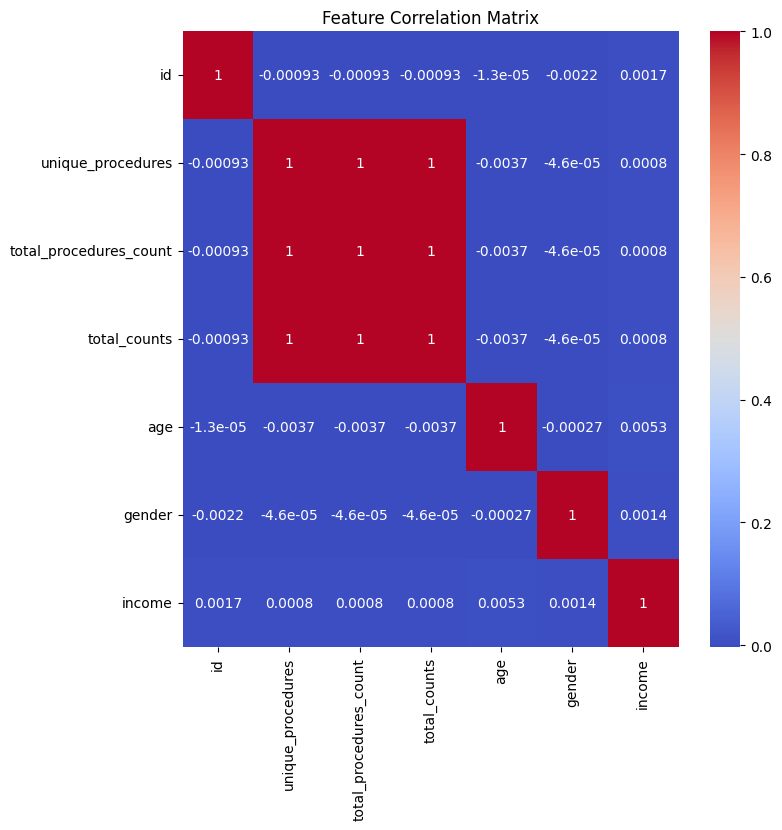

In [10]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Combine all relevant features into a single dataset
final_features = patient_txn_agg.merge(Patient_history, on='id')

# Correlation Matrix
correlation_matrix = final_features.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def calculate_vif(df):
    # Handle NaNs/Infs
    if df.isnull().values.any() or np.isinf(df.values).any():
        print("⚠️ Missing or infinite values detected. Imputing with median...")
        imputer = SimpleImputer(strategy='median')
        df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Assuming final_features is your dataset after preprocessing
numerical_features = final_features.select_dtypes(include=[np.number])
vif_result = calculate_vif(numerical_features)

print("✅ VIF Results:\n", vif_result)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


✅ VIF Results:
                   feature       VIF
0                      id  1.509423
1       unique_procedures       inf
2  total_procedures_count       inf
3            total_counts       inf
4                     age  1.000042
5                  gender  1.509426
6                  income  1.000030


In [28]:
# Selecting features with VIF < 5 and correlation |>0.5|
selected_features = vif_result[vif_result['VIF'] < 5]['feature'].tolist()
selected_features = [feat for feat in selected_features if correlation_matrix[feat].abs().max() > 0.5]

final_selected_data = final_features[selected_features]
print(f"✅ Selected Features for Modeling: {selected_features}")

✅ Selected Features for Modeling: ['id', 'age', 'gender', 'income']


### Step 2: Preprocessing Function

Goal: Create a preprocessing function that takes raw inputs and applies identical preprocessing as training data, without age mapping (encoded like income).

In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_input(raw_data, gender_encoder, income_encoder, scaler_patient, scaler_txn):
    # Encoding categorical variables
    raw_data['gender'] = gender_encoder.transform(raw_data['gender'])
    raw_data['age'] = income_encoder.transform(raw_data['age'])  # Encoded like income
    raw_data['income'] = income_encoder.transform(raw_data['income'])

    # Scaling
    raw_data[['age', 'income']] = scaler_patient.transform(raw_data[['age', 'income']])
    raw_data[['unique_procedures', 'total_procedures_count', 'total_counts']] = scaler_txn.transform(
        raw_data[['unique_procedures', 'total_procedures_count', 'total_counts']])

    return raw_data

print("✅ Preprocessing Function Updated.")

✅ Preprocessing Function Updated.


### Step 3: Isolation Forest Model Training & Evaluation

Goal: Train Isolation Forest with GridSearch for hyperparameter tuning using all features.

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_samples': ['auto', 0.8],
    'contamination': [0.01, 0.05],
    'random_state': [42]
}

iso_forest = IsolationForest()
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(final_features)

best_model = grid_search.best_estimator_
print(f"✅ Best Parameters: {grid_search.best_params_}")

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


✅ Best Parameters: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}


In [15]:
from sklearn.ensemble import IsolationForest

# ✅ Best Parameters from GridSearchCV applied
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,
    random_state=42
)

# ⚡ Fit the model
iso_forest.fit(final_features)

# 🔍 Predict anomalies (-1: anomaly, 1: normal)
predictions = iso_forest.predict(final_features)

# 📊 Evaluate anomalies
anomaly_count = (predictions == -1).sum()
anomaly_ratio = anomaly_count / len(predictions)

print(f"✅ Anomalies Detected: {anomaly_count} out of {len(predictions)}")
print(f"⚡ Anomaly Ratio: {anomaly_ratio:.4f}")



✅ Anomalies Detected: 5000 out of 500000
⚡ Anomaly Ratio: 0.0100


#### Decision Function Score Distribution:

✅ Decision Function Scores:
 [0.13753 0.10927 0.13094 ... 0.10659 0.13189 0.12406]


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


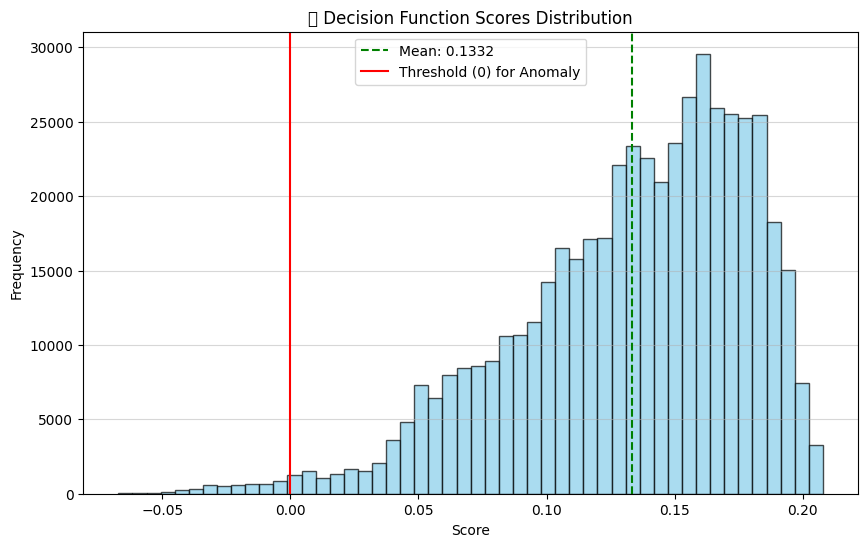

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ⚡ Get decision function scores
scores = best_model.decision_function(final_features)

# 📜 Print all score values
np.set_printoptions(precision=5, suppress=True)
print("✅ Decision Function Scores:\n", scores)

# 📊 Plot with mean and threshold (0) lines
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(scores), color='green', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
plt.axvline(x=0, color='red', linestyle='-', label='Threshold (0) for Anomaly')
plt.title("✅ Decision Function Scores Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


In [18]:
from scipy.stats import skew

score_skewness = skew(scores)
print(f"⚡ Skewness: {score_skewness:.4f}")

if score_skewness < 0:
    print("✅ Left-tailed (negatively skewed) distribution.")
elif score_skewness > 0:
    print("✅ Right-tailed (positively skewed) distribution.")
else:
    print("⚡ Symmetric distribution.")

⚡ Skewness: -0.8533
✅ Left-tailed (negatively skewed) distribution.


1. Anomaly Distribution Insight:
Bulk of Patients:
    Most patients have high decision scores ➔ normal behavior according to the model.
Anomalous Patients:
    The tail on the left means a small group has low scores, classified as anomalies.
    These anomalies represent cases that significantly deviate from typical patterns.

🏥 2. Healthcare-Specific Interpretation:
Given the Medicare anomaly detection context:
Potential Anomalies (Left Tail) could represent:
    Fraudulent claims or unusual treatment patterns
    Providers/patients with uncharacteristically low procedure diversity or counts

#### Silhouette Score

In [20]:
from sklearn.metrics import silhouette_score

# Isolation Forest output: -1 (anomaly), 1 (normal) — convert anomalies to 0 for silhouette
labels = [0 if x == -1 else 1 for x in predictions]
sil_score = silhouette_score(final_features, labels)
print(f"🌟 Silhouette Score: {sil_score:.4f}")

KeyboardInterrupt: 

#### Proportion of Anomalies in Top Low-Score Regions:

In [22]:
lowest_scores = np.percentile(scores, 1)  # Bottom 1%
print(f"Lowest 1% Decision Function Threshold: {lowest_scores:.5f}")


Lowest 1% Decision Function Threshold: 0.00000


### 3. Saving Model

In [ ]:
import pickle

with open("isolation_forest_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("✅ Model Saved Successfully as isolation_forest_model.pkl")